In [1]:
!pip install bs4

     |████████████████████████████████| 112kB 7.8MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4


In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

In [3]:
import requests 
from bs4 import BeautifulSoup 
import html5lib

## Processing of toronto dataset and created toronto_data_set

In [4]:
URL = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
r = requests.get(URL) 
soup = BeautifulSoup(r.content, 'html5lib') 

table = soup.find('table')
data = {'Postal Code': list(), 'Borough': list(), 'Neighborhood': list()}
for row in table.findAll('tr'): 
    splits = str(row).split('\n')
    code = splits[1].split('>')[1]
    borough = splits[3].split('>')[1]
    neighbor = splits[5].split('>')[1]
    if not (borough == 'Not assigned' or borough == 'Borough'):
        data['Postal Code'].append(code)
        data['Borough'].append(borough)
        data['Neighborhood'].append(neighbor.replace('/', ','))
        
toronto_df = pd.DataFrame(data, columns=('Postal Code', 'Borough', 'Neighborhood'))
data = pd.read_csv('Geospatial_Coordinates.csv')

Latitude = list()
Longitude = list()

for row in toronto_df['Postal Code']:
    lat = data[data['Postal Code'] == row]
    Latitude.append(str(lat['Latitude']).split()[1])
    Longitude.append(str(lat['Longitude']).split()[1])
    
toronto_df['Latitude'] = Latitude
toronto_df['Longitude'] = Longitude
toronto_df.drop(['Postal Code'], axis=1, inplace=True)
# toronto_df.to_csv('toronto_data_set.csv', index=None)

## Processing of neywork dataset to created manhattan_data_set

In [5]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset

with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
neighborhoods_data = newyork_data['features']
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
manhattan_df = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
# manhattan_data.to_csv('manhattan_data_set.csv', index=None)

## foursquare API info...

In [6]:
CLIENT_ID = 'XB5250OGQ0DUG3SJPTCSGZL4CSXRK3LMMQTC3IYSJZUITSCK' # your Foursquare ID
CLIENT_SECRET = 'ZPNHLLVWQ0TKF3DWDKPHI23XHNRF5NEPNMIFJPYJW5CE5TLL' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
radius = 500
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: XB5250OGQ0DUG3SJPTCSGZL4CSXRK3LMMQTC3IYSJZUITSCK
CLIENT_SECRET:ZPNHLLVWQ0TKF3DWDKPHI23XHNRF5NEPNMIFJPYJW5CE5TLL


In [7]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
#         print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]["groups"][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

## Preprocessing of toronto data

In [8]:
toronto_venues = getNearbyVenues(names=toronto_df['Neighborhood'],
                                   latitudes=toronto_df['Latitude'],
                                   longitudes=toronto_df['Longitude'])

In [9]:
manhattan_venues = getNearbyVenues(names=manhattan_df['Neighborhood'],
                                   latitudes=manhattan_df['Latitude'],
                                   longitudes=manhattan_df['Longitude'])

In [10]:
toronto_venues.shape

(2137, 7)

In [11]:
manhattan_venues.shape

(2988, 7)

## Creating one data set using toronto & manhatan data

In [12]:
data_venues = pd.concat([toronto_venues, manhattan_venues])

In [13]:
data_venues.shape

(5125, 7)

In [14]:
data_venues.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,4,4,4,4,4,4
"Alderwood, Long Branch",10,10,10,10,10,10
"Bathurst Manor, Wilson Heights, Downsview North",19,19,19,19,19,19
Battery Park City,60,60,60,60,60,60
Bayview Village,4,4,4,4,4,4


In [15]:
# one hot encoding
data_onehot = pd.get_dummies(data_venues[['Venue Category']], prefix="", prefix_sep="")
data_onehot.shape

(5125, 382)

In [16]:
lst = (list(data_onehot.columns))
lst.remove('Neighborhood')
len(lst)

381

In [17]:
# move neighborhood column to the first column
fixed_columns = ['Neighborhood'] + lst
data_onehot = data_onehot[fixed_columns]

data_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Auditorium,College Bookstore,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Moving Target,Museum,Music School,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Per

In [18]:
# add neighborhood column back to dataframe
data_onehot['Neighborhood'] = data_venues['Neighborhood']
data_onehot.shape

(5125, 382)

In [19]:
data_grouped = data_onehot.groupby('Neighborhood').mean().reset_index()
# data_grouped

In [20]:
data_grouped.shape

(136, 382)

In [21]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

## Top venues for each and every neighborhood of toronto and manhattan

In [22]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
data_venues_sorted = pd.DataFrame(columns=columns)
data_venues_sorted['Neighborhood'] = data_grouped['Neighborhood']

for ind in np.arange(data_grouped.shape[0]):
    data_venues_sorted.iloc[ind, 1:] = return_most_common_venues(data_grouped.iloc[ind, :], num_top_venues)

data_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Latin American Restaurant,Breakfast Spot,Lounge,Skating Rink,Yoga Studio,Empanada Restaurant,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop
1,"Alderwood, Long Branch",Pizza Place,Pool,Pub,Sandwich Place,Pharmacy,Dance Studio,Skating Rink,Coffee Shop,Gym,Dumpling Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Pizza Place,Bridal Shop,Sushi Restaurant,Shopping Mall,Fried Chicken Joint,Gas Station,Sandwich Place,Middle Eastern Restaurant
3,Battery Park City,Park,Hotel,Gym,Memorial Site,Coffee Shop,Playground,Beer Garden,Shopping Mall,Mexican Restaurant,Plaza
4,Bayview Village,Chinese Restaurant,Bank,Café,Japanese Restaurant,Yoga Studio,Empanada Restaurant,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop


In [23]:
data_venues_sorted.shape

(136, 11)

In [24]:
data_venues_sorted['Neighborhood'].head()

0                                          Agincourt
1                             Alderwood, Long Branch
2    Bathurst Manor, Wilson Heights, Downsview North
3                                  Battery Park City
4                                    Bayview Village
Name: Neighborhood, dtype: object

In [25]:
# data_venues_sorted['region'] = region
# data_venues_sorted.drop('region', axis=1, inplace=True)
data_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Latin American Restaurant,Breakfast Spot,Lounge,Skating Rink,Yoga Studio,Empanada Restaurant,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop
1,"Alderwood, Long Branch",Pizza Place,Pool,Pub,Sandwich Place,Pharmacy,Dance Studio,Skating Rink,Coffee Shop,Gym,Dumpling Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Pizza Place,Bridal Shop,Sushi Restaurant,Shopping Mall,Fried Chicken Joint,Gas Station,Sandwich Place,Middle Eastern Restaurant
3,Battery Park City,Park,Hotel,Gym,Memorial Site,Coffee Shop,Playground,Beer Garden,Shopping Mall,Mexican Restaurant,Plaza
4,Bayview Village,Chinese Restaurant,Bank,Café,Japanese Restaurant,Yoga Studio,Empanada Restaurant,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop


In [26]:
data_grouped.shape

(136, 382)

## Clustering...

In [27]:
# set number of clusters
kclusters = 5

data_grouped_clustering = data_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(data_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ 

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 3, 2,
       2, 0, 4, 2], dtype=int32)

In [28]:
# add clustering labels
data_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [29]:
region = list()
for i in data_venues_sorted['Neighborhood']:
    if i in set(toronto_venues['Neighborhood']):
        region.append('toronto')
    else:
        region.append('manhattan')

In [30]:
data_venues_sorted['region'] = region

In [31]:
cluster1 = data_venues_sorted[data_venues_sorted['Cluster Labels'] == 0]
cluster2 = data_venues_sorted[data_venues_sorted['Cluster Labels'] == 1]
cluster3 = data_venues_sorted[data_venues_sorted['Cluster Labels'] == 2]
cluster4 = data_venues_sorted[data_venues_sorted['Cluster Labels'] == 3]
cluster5 = data_venues_sorted[data_venues_sorted['Cluster Labels'] == 4]

In [52]:
(cluster3['region'].value_counts())

toronto      79
manhattan    40
Name: region, dtype: int64

In [53]:
clusters = ['cluster1', 'cluster2', 'cluster3', 'cluster4', 'cluster5']
toronto = [cluster1['region'].value_counts()[0], 
           cluster2['region'].value_counts()[0], 
           cluster3['region'].value_counts()[0], 
           cluster4['region'].value_counts()[0], 
           cluster5['region'].value_counts()[0]]
manhattan = [0, 0, 40, 0, 0]

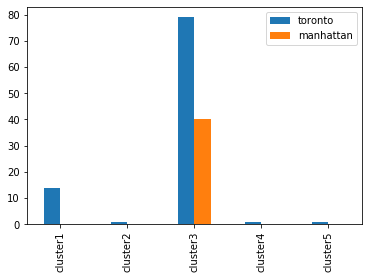

In [54]:
df = pd.DataFrame({'toronto': toronto, 'manhattan': manhattan}, index=clusters)
df.plot.bar()

## As shown in above diagram, manhattan and toronto are really very different. But there are still many places where you can relocate if needed ( neighborhood from cluster 3 ).

## Cluster3 analysis

In [57]:
cluster3.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,region
0,2,Agincourt,Latin American Restaurant,Breakfast Spot,Lounge,Skating Rink,Yoga Studio,Empanada Restaurant,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,toronto
1,2,"Alderwood, Long Branch",Pizza Place,Pool,Pub,Sandwich Place,Pharmacy,Dance Studio,Skating Rink,Coffee Shop,Gym,Dumpling Restaurant,toronto
2,2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Pizza Place,Bridal Shop,Sushi Restaurant,Shopping Mall,Fried Chicken Joint,Gas Station,Sandwich Place,Middle Eastern Restaurant,toronto
3,2,Battery Park City,Park,Hotel,Gym,Memorial Site,Coffee Shop,Playground,Beer Garden,Shopping Mall,Mexican Restaurant,Plaza,manhattan
4,2,Bayview Village,Chinese Restaurant,Bank,Café,Japanese Restaurant,Yoga Studio,Empanada Restaurant,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,toronto


### If you are some one from Battery park city, manhattan and wants to relocate somewhere in toronto than Bayvies Village,toronto and Alderwood,toronto can be good option for you.

In [62]:
pd.DataFrame(set(cluster3[cluster3['region'] == 'toronto']['Neighborhood']))

,0
0,"Bedford Park, Lawrence Manor East"
1,"Alderwood, Long Branch"
2,"Queen's Park, Ontario Provincial Government"
3,"Golden Mile, Clairlea, Oakridge"
4,Canada Post Gateway Processing Centre
5,Christie
6,"First Canadian Place, Underground city"
7,"Richmond, Adelaide, King"
8,"Little Portugal, Trinity"
9,"South Steeles, Silverstone, Humbergate, Jamest..."


## If you lives somewhere from the above list of Neighborhood, toronto